In [1]:
import numpy as np
import os
import pandas as pd
import h5py
from scipy.io import loadmat
import socket
import matplotlib.pyplot as plt
import seaborn as sns

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['ALI_evoked'] = os.path.join(p['EEGfiles'], 'ALI_evoked.mat')
p['ALI_induced'] = os.path.join(p['EEGfiles'], 'ALI_induced.mat')
p['training_data'] = os.path.join(p['EEGfiles'], 'training_data.npy')
# Load up summary meta-data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))
All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}

# Load up behavioral data
df_behav = pd.read_csv(p['df_fname'])
df_behav['trl_idx'] = df_behav['rnum'] * df_behav['tnum']

In [7]:
p['ALI_evoked']

'/d/DATD/datd/MD_TMS_EEG/EEGfiles/ALI_evoked.mat'

In [2]:
with h5py.File(p['ALI_evoked'], 'r') as f:
    X_evoked = np.array(f['mALI']).T
    y_evoked = np.array(f['trl_mat']).T

with h5py.File(p['ALI_induced'], 'r') as f:
    X_induced = np.array(f['mALI']).T
    y_induced = np.array(f['trl_mat']).T

In [3]:
y_df = pd.DataFrame(y_induced, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')
y_df.shape

(20064, 5)

/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_70063/1082280225.py:5: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_evoked[idx_ivf, :], 0), 'k-')
/var/folders/0w/p5w49zc93976_p2hxj1zws2w0000gn/T/ipykernel_70063/1082280225.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(X_evoked[idx_ovf, :], 0), 'b-')


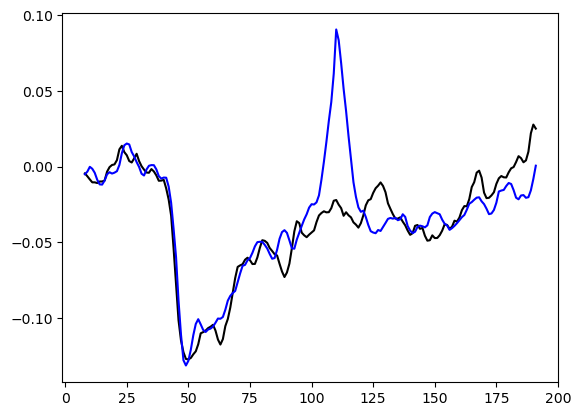

In [25]:
idx_ivf = y_df.loc[(y_df['istms'] == 0) & (y_df['t_type'] == 1)].index
idx_ovf = y_df.loc[(y_df['istms'] == 1) & (y_df['t_type'] == 1)].index

plt.figure()
plt.plot(np.nanmean(X_evoked[idx_ivf, :], 0), 'k-')
plt.plot(np.nanmean(X_evoked[idx_ovf, :], 0), 'b-')

In [21]:
idx_ovf

Index([], dtype='int64')

In [7]:
common_df = pd.merge(df_behav, y_df, on=['subjID', 'day', 'trl_idx'], how='inner', indicator=True)
y_df_reset = y_df.reset_index()
common_df = pd.merge(df_behav, y_df_reset, on=['subjID', 'day', 'trl_idx'], how='inner')

In [8]:
retained_indices = common_df['index'].unique()
retained_indices = np.sort(retained_indices)

In [10]:
len(retained_indices)

8734

In [12]:
common_df.shape

(16878, 58)

In [14]:
summary_y_df = y_df.groupby(['subjID', 'day'])['trl_idx'].max().reset_index(name='count_y')
summary_y_df.head(100)

,subjID,day,count_y
0,1,1,400
1,1,2,400
2,1,3,400
3,3,1,400
4,3,2,400
5,3,3,400
6,5,1,400
7,5,2,400
8,5,3,400
9,6,1,400


In [33]:
df_behav.shape

(23222, 56)

In [34]:
y_df.shape

(20066, 5)

In [29]:
common_df.shape

(16871, 58)

In [5]:
sub_list = [1]
day_list = [1, 2, 3]
conditions = ['pin', 'pout', 'ain', 'aout']

data_dict = {cond: {ss: {dd: [] for dd in day_list} for ss in sub_list} for cond in conditions}

subject_day_info = []
freq_band = (8, 12)
time_band = (-1, 4.5)
ch_count = None
time_points = None
tr_count = 0

tfr_type = 'evoked'

if os.path.exists(p['training_data']):
    data_matrix = np.load(p['training_data'])
else:
    for cond in conditions:
        for ss in sub_list:
            for dd in day_list:
                this_fname = os.path.join(p['EEGfiles'], f'sub{ss:02}', f'day{dd:02}', f'sub{ss:02}_day{dd:02}_TFR_'+tfr_type+'.mat')
                with h5py.File(this_fname, 'r') as f:
                    # Load the time-frequency data
                    powspctrm = np.array(f['POW'][cond]['powspctrm'])
                    ch_labels = np.array(f['POW'][cond]['label']).astype(str)
                    # Create order of channel labels first time running this
                    if tr_count == 0:
                        standard_labels = ch_labels
                    
                    # Reorder data for channel indices are different from the one in first dataset
                    channel_indices = np.array([np.where(standard_labels == ch)[0][0] for ch in ch_labels])
                    powspctrm = powspctrm[:, :, channel_indices, :]

                    # Slice along the time of interest -1 to 4.5 seconds
                    time = np.array(f['POW'][cond]['time'])
                    time_band_indices = np.where((time >= time_band[0]) & (time <= time_band[1]))[0]
                    powspctrm = powspctrm[time_band_indices, :, :, :]

                    # Average over the alpha band
                    freqs = np.array(f['POW'][cond]['freq'])
                    freq_band_indices = np.where((freqs >= freq_band[0]) & (freqs <= freq_band[1]))[0]
                    powspctrm_avg = np.mean(powspctrm[:, freq_band_indices, :, :], axis=1)

                    # Reorder X_avg in the shape (trials, channels, time)
                    powspctrm_avg = np.transpose(powspctrm_avg, (2, 1, 0))

                    data_dict[cond][ss][dd] = powspctrm_avg

                    if ch_count is None:
                        ch_count = powspctrm_avg.shape[1]
                    if time_points is None:
                        time_points = powspctrm_avg.shape[2]
                    tr_count += powspctrm_avg.shape[0]

    data_matrix = np.zeros((len(conditions), len(sub_list), len(day_list), tr_count, ch_count, time_points))
    current_trial_index = 0

    for cond_idx, cond in enumerate(conditions):
        for ss_idx, ss in enumerate(sub_list):
            for dd_idx, dd in enumerate(day_list):
                data = data_dict[cond][ss][dd]
                num_trials = data.shape[0]
                data_matrix[cond_idx, ss_idx, dd_idx, current_trial_index:current_trial_index+num_trials, :, :] = data
                current_trial_index += num_trials

    np.save(p['training_data'], data_matrix)

(4, 1, 3, 1189, 62, 146)


In [ ]:
aa = np.transpose(X_avg, (2, 1, 0))
print(aa.shape)

In [ ]:
time.shape